# Tutorial on collocaing a daTASET  with lagged dat

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 
from geopy.distance import geodesic 

####################you will need to change some paths here!#####################
#list of input files
#filename_bird='f:/data/project_data/NASA_biophysical/collocated_data/zoo_selgroups_HadSST_relabundance_5aug2019_plumchrusV_4regions_final.csv'
#output files
filename_bird='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final.nc'
filename_bird_out='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final_color.csv'
filename_bird_out_netcdf='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_wide_sat_and_eddy_data_final_color.nc'
#################################################################################


## Reading CSV datasets

In [13]:
#read in csv file in to panda dataframe & into xarray
#df_bird = pd.read_csv(filename_bird)
ds_bird = xr.open_dataset(filename_bird) #df_bird.to_xarray()
ilen_bird = len(ds_bird.lat)
ds_bird

<xarray.Dataset>
Dimensions:                 (index: 92738)
Coordinates:
  * index                   (index) int64 0 1 2 3 4 ... 92734 92735 92736 92737
Data variables:
    Unnamed: 0              (index) int64 ...
    Master.Key              (index) object ...
    Modified.Platform.Type  (index) object ...
    Fly.Bird.Method         (index) object ...
    Year                    (index) int64 ...
    Month                   (index) int64 ...
    Day                     (index) int64 ...
    Julian.Date             (index) int64 ...
    Sample.Area             (index) float64 ...
    PI.Credit               (index) object ...
    lon                     (index) float64 ...
    lat                     (index) float64 ...
    ANMU                    (index) int64 ...
    ARTE                    (index) int64 ...
    BLKI                    (index) int64 ...
    BOGU                    (index) int64 ...
    CAAU                    (index) int64 ...
    CAGU                    (index) int64 ...
    COLO                    (index) int64 ...
    CRAU                    (index) int64 ...
    DCCO                    (index) int64 ...
    FTSP                    (index) int64 ...
    GWGU                    (index) int64 ...
    HERG                    (index) int64 ...
    HOPU                    (index) int64 ...
    LEAU                    (index) int64 ...
    LESP                    (index) int64 ...
    MEGU                    (index) int64 ...
    NOFU                    (index) int64 ...
    PAAU                    (index) int64 ...
    PALO                    (index) int64 ...
    PIGU                    (index) int64 ...
    RHAU                    (index) int64 ...
    SAGU                    (index) int64 ...
    TUPU                    (index) int64 ...
    WHAU                    (index) int64 ...
    ALLSH                   (index) int64 ...
    ALLMU                   (index) int64 ...
    ALLBRMU                 (index) int64 ...
    GACO                    (index) int64 ...
    ALLALB                  (index) int64 ...
    ALLPE                   (index) int64 ...
    ALLJA                   (index) int64 ...
    time                    (index) datetime64[ns] ...
    amplitude               (index) float32 ...
    cyclonic_type           (index) float64 ...
    lat_eddy                (index) float32 ...
    lon_eddy                (index) float32 ...
    observation_number      (index) float64 ...
    speed_average           (index) float32 ...
    speed_radius            (index) float32 ...
    track                   (index) float64 ...
    time64                  (index) datetime64[ns] ...
    save_eddy_distance      (index) float32 ...
    aviso_adt               (index) float64 ...
    aviso_sla               (index) float64 ...
    aviso_ugos              (index) float64 ...
    aviso_ugosa             (index) float64 ...
    aviso_vgos              (index) float64 ...
    aviso_vgosa             (index) float64 ...
    ccmp_uwnd               (index) float32 ...
    ccmp_vwnd               (index) float32 ...
    cmc_sst                 (index) float32 ...
    ETOPO_depth             (index) float64 ...

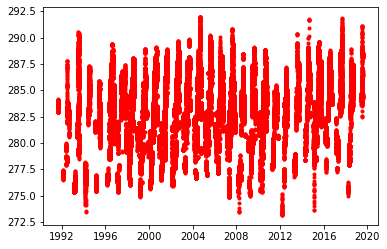

In [14]:
#clean up ds_bird so that zero are nan
cond= (ds_bird.cmc_sst>100)
clean = ds_bird.where(cond)
dlist = ['cmc_sst']
for var in dlist:
    ds_bird[var]=clean[var]
#plt.plot(ds_bird.time,ds_bird.cmc_sst,'b.')
plt.plot(clean.time,clean.cmc_sst,'r.')

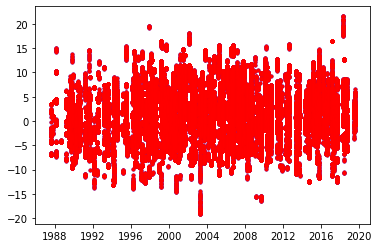

In [15]:
#clean up ds_bird so that zero are nan
cond= (ds_bird.ccmp_uwnd!=0)
clean = ds_bird.where(cond)
dlist = ['ccmp_uwnd','ccmp_vwnd']
for var in dlist:
    ds_bird[var]=clean[var]
plt.plot(ds_bird.time,ds_bird.ccmp_vwnd,'b.')
plt.plot(clean.time,clean.ccmp_vwnd,'r.')

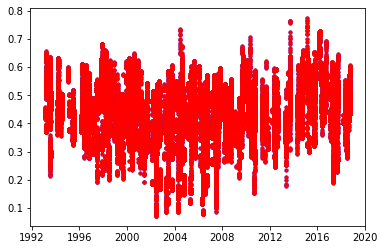

In [16]:
#clean up ds_bird so that zero are nan
cond= (ds_bird.aviso_adt>.01)
clean = ds_bird.where(cond)
dlist = ['aviso_adt','aviso_sla','aviso_ugos','aviso_ugosa','aviso_vgos','aviso_vgosa']
for var in dlist:
    ds_bird[var]=clean[var]
plt.plot(ds_bird.time,ds_bird.aviso_adt,'b.')
plt.plot(clean.time,clean.aviso_adt,'r.')

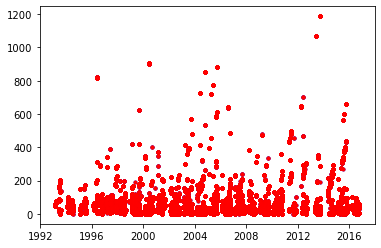

In [17]:
#clean up ds_bird so that zero are nan
cond= (ds_bird.cyclonic_type>.1) | (ds_bird.cyclonic_type<-.1)
clean = ds_bird.where(cond)
dlist = ['observation_number','cyclonic_type','lat_eddy','lon_eddy','speed_average','speed_radius','track','save_eddy_distance']
for var in dlist:
    ds_bird[var]=clean[var]
plt.plot(ds_bird.time,ds_bird.observation_number,'b.')
plt.plot(clean.time,clean.observation_number,'r.')

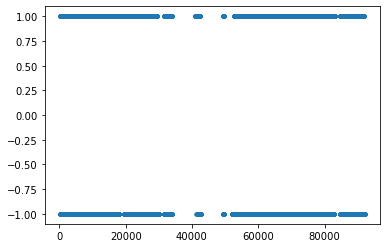

In [18]:
plt.plot(ds_bird.cyclonic_type,'.')

In [8]:

ds_color = xr.open_dataset('https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v4.2-DAILY')
#ds_color = xr.open_dataset('https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v4.2-8DAY')
for var in ds_color:
    if not var=='chlor_a':
        ds_color = ds_color.drop(var)
ds_color

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, time: 8128)
Coordinates:
  * lat      (lat) float32 89.979164 89.9375 89.895836 ... -89.9375 -89.979164
  * lon      (lon) float32 -179.97917 -179.9375 ... 179.9375 179.97917
  * time     (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2019-12-31
Data variables:
    chlor_a  (time, lat, lon) float32 ...
Attributes:
    Conventions:                    CF-1.7
    start_date:                     30-DEC-2019 00:00:00.000000
    stop_date:                      30-DEC-2019 23:59:00.000000
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20200121T164055Z
    creator_email:                  help@esa-oceancolour-cci.org
    creator_name:                   Plymouth Marine Laboratory
    creator_url:                    http://esa-oceancolour-cci.org
    date_created:                   20200121T164055Z
    geospatial_lat_max:             90.0
    geospatial_lat_min:             -90.0
    geospatial_lat_resolution:      .04166666666666666666
    geospatial_lat_units:           decimal degrees north
    geospatial_lon_max:             180.0
    geospatial_lon_min:             -180.0
    geospatial_lon_resolution:      .04166666666666666666
    geospatial_lon_units:           decimal degrees east
    geospatial_vertical_max:        0.0
    geospatial_vertical_min:        0.0
    history:                        Source data were: NASA OBPG SeaWiFS level...
    institution:                    Plymouth Marine Laboratory
    keywords:                       satellite,observation,ocean,ocean colour
    keywords_vocabulary:            none
    license:                        ESA CCI Data Policy: free and open access...
    naming_authority:               uk.ac.pml
    number_of_optical_water_types:  14
    platform:                       Orbview-2,Aqua,Envisat,Suomi-NPP
    processing_level:               Level-3
    project:                        Climate Change Initiative - European Spac...
    references:                     http://www.esa-oceancolour-cci.org/
    sensor:                         SeaWiFS,MODIS,MERIS,VIIRS
    sensors_present:                 MODISA VIIRSN
    source:                         NASA SeaWiFS L2 R2018.0 LAC and GAC, MODI...
    spatial_resolution:             4km nominal at equator
    standard_name_vocabulary:       NetCDF Climate and Forecast (CF) Metadata...
    summary:                        Data products generated by the Ocean Colo...
    time_coverage_duration:         P1D
    time_coverage_end:              201912302359Z
    time_coverage_resolution:       P1D
    time_coverage_start:            201912300000Z
    title:                          ESA CCI Ocean Colour Product
    id:                             ESACCI-OC-L3S-OC_PRODUCTS-MERGED-1D_DAILY...
    product_version:                4.2
    tracking_id:                    23dae2e8-04ff-4d5c-b101-abc77fbd9db2
    git_commit_hash:                85e7d70ef28f64e1c0f9b7f8212b97157a4f1278

47.72 61.24 -179.58 -122.62
1970-01-01T00:00:00.000000000 2247-03-11T01:12:42.982416720


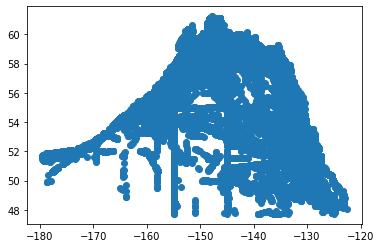

In [9]:
#just check lat/lon & see looks okay
minlat,maxlat=ds_bird.lat.min(),ds_bird.lat.max()
minlon,maxlon=ds_bird.lon.min(),ds_bird.lon.max()
plt.scatter(ds_bird.lon,ds_bird.lat)
print(minlat.data,maxlat.data,minlon.data,maxlon.data)
print(ds_bird.time64.min().data,ds_bird.time64.max().data)

# Collocate all data with bird data

In [ ]:
ilen_bird = len(ds_bird.lat)
ds_data = ds_color
for var in ds_data:
    var_tem=var
    ds_bird[var_tem]=xr.DataArray(np.nan*np.empty(ilen_bird, dtype=str(ds_data[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
    ds_bird[var_tem].attrs=ds_data[var].attrs
print('var',var_tem)
for i in range(ilen_bird):
    t1,t2 = ds_bird.time64[i]-np.timedelta64(5,'D'), ds_bird.time64[i]+np.timedelta64(5,'D')
    lat1,lat2=ds_bird.lat[i]+.1,ds_bird.lat[i]-.1
    lon1,lon2=ds_bird.lon[i]-.1,ds_bird.lon[i]+.1
    tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
    if len(tem)<1:
        continue
    tem = tem.mean(keep_attrs=True)
    for var in ds_data:
        var_tem=var
        ds_bird[var_tem][i]=tem[var].data
    if int(i/100)*100==i:
        print(i,len(ds_bird.lat))
#output data
df_bird = ds_bird.to_dataframe()
df_bird.to_csv(filename_bird_out)
ds_bird.to_netcdf(filename_bird_out_netcdf)

var chlor_a
0 92738
100 92738
200 92738
300 92738
400 92738
500 92738
600 92738
700 92738
800 92738
900 92738
1000 92738
1100 92738
1200 92738
1300 92738
1400 92738
1500 92738
1600 92738
1700 92738
1800 92738
1900 92738
2000 92738
2100 92738
2200 92738
2300 92738
2400 92738
2500 92738
2600 92738
2700 92738
2800 92738
2900 92738
3000 92738
3100 92738
3200 92738
3300 92738
3400 92738
3500 92738
3600 92738
3700 92738
3800 92738
3900 92738
4000 92738
4100 92738
4200 92738
4300 92738
4400 92738
4500 92738
4600 92738
4700 92738
4800 92738
4900 92738
5000 92738
5100 92738
5200 92738
5300 92738
5400 92738
5500 92738
5600 92738
5700 92738
5800 92738
5900 92738
6000 92738
6100 92738
6200 92738
6300 92738
6400 92738
6500 92738
6600 92738
6700 92738
6800 92738
6900 92738
7000 92738
7100 92738
7200 92738
7300 92738
7400 92738
7500 92738
7600 92738
7700 92738
7800 92738
7900 92738
8000 92738
8100 92738
8200 92738
8300 92738
8400 92738
8500 92738
8600 92738
8700 92738
8800 92738
8900 92738
9000 92738

69200 92738
69300 92738
69400 92738
69500 92738
69600 92738
69700 92738
69800 92738
69900 92738
70000 92738
70100 92738
70200 92738
70300 92738
70400 92738
70500 92738
70600 92738
70700 92738
70800 92738
70900 92738
71000 92738
71100 92738
71200 92738
71300 92738
71400 92738
71500 92738
71600 92738


In [ ]:



ilen_bird = len(ds_bird.lat)
ds_data = ds_color
for var in ds_data:
    var_tem=var
    ds_bird[var_tem]=xr.DataArray(np.empty(ilen_bird, dtype=str(ds_data[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
    ds_bird[var_tem].attrs=ds_data[var].attrs
print('var',var_tem)
i=10000
#for i in range(len(ds_bird.lat)):
#    for i in range(len(ds_bird.lat)):
#    if ds_bird.time[i]<ds_data.time.min():
#        continue
#    if ds_bird.time[i]>ds_data.time.max():
#        continue
t1,t2 = ds_bird.time64[i]-np.timedelta64(5,'D'), ds_bird.time64[i]+np.timedelta64(5,'D')
lat1,lat2=ds_bird.lat[i]+.1,ds_bird.lat[i]-.1
lon1,lon2=ds_bird.lon[i]-.1,ds_bird.lon[i]+.1
tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
